<h1 style="color: #232ED1;">📊 Course Recommender System on Web App</h1>



<h2 style="color: #232ED1;">Import Dependencies</h2>

In [1]:
# Import Dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
import pickle
import nltk
import re

# Download wordnet once (if needed)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print('Dependencies Imported')

Dependencies Imported


[nltk_data] Downloading package wordnet to /Users/bushra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import os
current_directory = os.getcwd()
print(current_directory)


/Users/bushra/data-science/upwork/education-projects/03/course-recommendation-system/notebooks


In [3]:
%cd ..

/Users/bushra/data-science/upwork/education-projects/03/course-recommendation-system


/Users/bushra/data-science/upwork/education-projects/03/course-recommendation-system/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


<h2 style="color: #232ED1;">Load Dataset</h2>

In [4]:
import pandas as pd

# Function to load CSV data
def load_data(file_path):
    try:
        data = pd.read_csv(file_path, encoding='utf-8')
        return data
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None

# Loading the data from a local file
data = load_data("../course-recommendation-system/data/coursera.csv")


In [5]:
data.head()

,Course Name,University,Difficulty Level,Course Rating,Course URL,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


<h2 style="color: #232ED1;">Basic Data Inspection</h2>

In [7]:
# Display dataset shape (number of rows and columns)
data.shape

(3522, 7)

In [8]:
# Show summary of the dataset (information on column types and memory usage)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Name         3522 non-null   object
 1   University          3522 non-null   object
 2   Difficulty Level    3522 non-null   object
 3   Course Rating       3522 non-null   object
 4   Course URL          3522 non-null   object
 5   Course Description  3522 non-null   object
 6   Skills              3522 non-null   object
dtypes: object(7)
memory usage: 192.7+ KB


In [9]:
# Check for missing values in each column
print(data.isnull().sum())

Course Name           0
University            0
Difficulty Level      0
Course Rating         0
Course URL            0
Course Description    0
Skills                0
dtype: int64


In [10]:
# Display the number of unique values for each column (useful to identify categorical variables)
print(data.nunique())

Course Name           3416
University             184
Difficulty Level         5
Course Rating           31
Course URL            3424
Course Description    3397
Skills                3424
dtype: int64


In [11]:
# Remove duplicates based on specific columns
data = data.drop_duplicates(subset=['Course Name', 'University', 'Difficulty Level', 'Course Rating',
       'Course URL', 'Course Description'])
data.shape

(3424, 7)

<h2 style="color: #232ED1;">Check the Distribution of Key Columns</h2>

/var/folders/fh/kyml8tjs61j6z54n3h59ptwh0000gn/T/ipykernel_11894/2219308396.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index[:top_n], y=value_counts.values[:top_n], palette='bright')


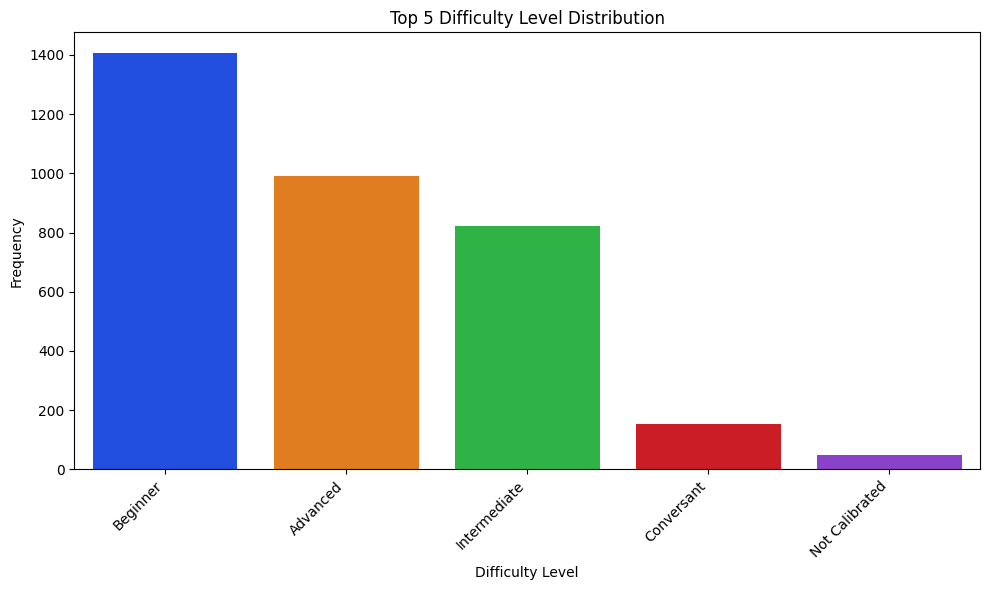

/var/folders/fh/kyml8tjs61j6z54n3h59ptwh0000gn/T/ipykernel_11894/2219308396.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index[:top_n], y=value_counts.values[:top_n], palette='bright')


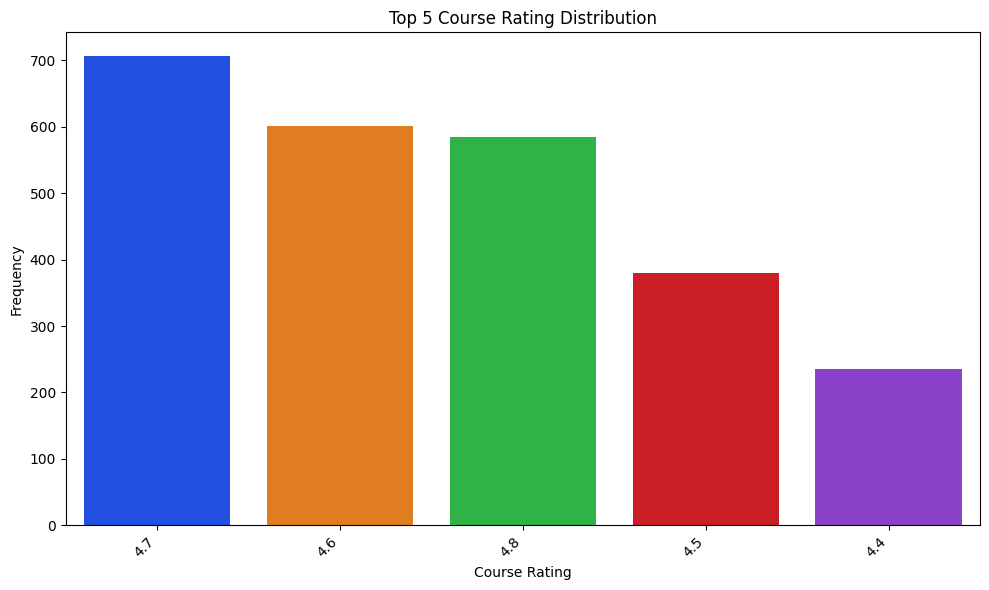

/var/folders/fh/kyml8tjs61j6z54n3h59ptwh0000gn/T/ipykernel_11894/2219308396.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index[:top_n], y=value_counts.values[:top_n], palette='bright')


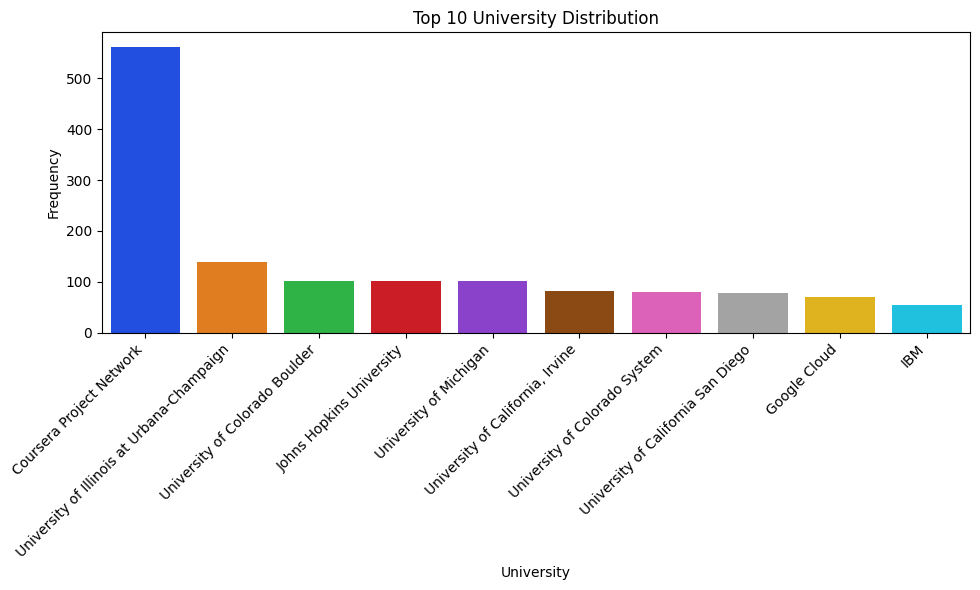


Total Unique Universities: 184


In [12]:
# Function to display and visualize distributions for categorical columns
def display_distribution(column_name, data, top_n=10, sort_by_value=True, visualize=True):
    
    # Get the value counts
    value_counts = data[column_name].value_counts()

    # Sort values if necessary
    if sort_by_value:
        value_counts = value_counts.sort_values(ascending=False)
    
    # Optional: Plot the distribution
    if visualize:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=value_counts.index[:top_n], y=value_counts.values[:top_n], palette='bright')
        plt.title(f"Top {top_n} {column_name} Distribution")
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Displaying the distributions
display_distribution('Difficulty Level', data, top_n=5)  # Adjust top_n as needed
display_distribution('Course Rating', data, top_n=5)
display_distribution('University', data, top_n=10, sort_by_value=False)  # For universities, you might not want to sort by count

# Showing the count of unique universities
print(f"\nTotal Unique Universities: {data['University'].nunique()}")


<h2 style="color: #232ED1;">Text Preprocessing</h2>

In [13]:
lemmatizer = WordNetLemmatizer()

# Function for text cleaning (removing special characters, stopwords, and lemmatization)
def clean_text(text):
    text = re.sub(r'��+', '', text)  # This removes "��" or any repeated "��" characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Removes non-ASCII characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove anything that is not a letter or space
    text = text.lower()  # Convert text to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatization
    return text

# Apply text cleaning to necessary columns
data['Course Name'] = data['Course Name'].apply(clean_text)
data['Course Description'] = data['Course Description'].apply(clean_text)
data['Skills'] = data['Skills'].apply(clean_text)

# Combine 'Course Name', 'Course Description', and 'Skills' into 'tags'
data['tags'] = data['Course Name'] + ' ' + data['Course Description'] + ' ' + data['Skills']
print(data[['Course Name', 'tags']].head())


                                         Course Name  \
0  write a feature length screenplay for film or ...   
1  business strategy business model canvas analys...   
2                       silicon thin film solar cell   
3                                finance for manager   
4          retrieve data using singletable sql query   

                                                tags  
0  write a feature length screenplay for film or ...  
1  business strategy business model canvas analys...  
2  silicon thin film solar cell this course consi...  
3  finance for manager when it come to number the...  
4  retrieve data using singletable sql query in t...  


In [14]:
# Memory efficient datatypes

In [15]:
# Convert 'University' and 'Difficulty Level' to categorical to save memory
data['University'] = data['University'].astype('category')
data['Difficulty Level'] = data['Difficulty Level'].astype('category')

# Optimize 'Course Rating' column to save memory
data['Course Rating'] = data['Course Rating'].apply(lambda x: 0.0 if x == 'Not Calibrated' else pd.to_numeric(x, errors='coerce'))
data['Course Rating'] = data['Course Rating'].astype('float32')


<h2 style="color: #232ED1;">Text Vectorization (TF-IDF)</h2>

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(data['tags'])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (3424, 5000)


In [17]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD to reduce dimensions of the TF-IDF matrix
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix = svd.fit_transform(tfidf_matrix)

print("Reduced TF-IDF matrix shape:", tfidf_matrix.shape)


Reduced TF-IDF matrix shape: (3424, 100)


<h2 style="color: #232ED1;">Cosine Similarity and Recommendations</h2>

In [18]:
similarity_matrix = cosine_similarity(tfidf_matrix)
print(similarity_matrix[0][1])

0.023688637916059643


<h2 style="color: #232ED1;">Recommendation Function</h2>

In [19]:
# Ensure 'Course Rating' is numeric, and handle errors gracefully
data['Course Rating'] = pd.to_numeric(data['Course Rating'], errors='coerce')
# Normalize ratings (if ratings are between 1 and 5)
data['Normalized Rating'] = (data['Course Rating'] - data['Course Rating'].min()) / (data['Course Rating'].max() - data['Course Rating'].min())

def recommend(course_name, top_n=5, threshold=70, min_rating=3):
    """
    Recommend courses based on course name, taking into account both cosine similarity and ratings.

    Args:
    - course_name (str): Name of the course to base recommendations on.
    - top_n (int): Number of top recommendations to display.
    - threshold (int): Minimum similarity score for a course to be recommended.
    - min_rating (int): Minimum rating a course must have to be recommended.
    """
        
        similarity_scores = list(enumerate(similarity_matrix[course_idx]))
        sorted_courses = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:]
        
        recommended_courses = []
        
        # Adjust recommendations using ratings
        for idx, sim_score in sorted_courses[:top_n]:
            course_rating = data.iloc[idx]['Course Rating']
            if pd.isna(course_rating):
                course_rating = data['Course Rating'].mean()  # Fallback to mean rating

            # Normalize similarity score
            sim_score = float(sim_score)
            sim_min, sim_max = min(sim_score for _, sim_score in sorted_courses), max(sim_score for _, sim_score in sorted_courses)
            normalized_sim_score = (sim_score - sim_min) / (sim_max - sim_min)

            # Weighted scoring: 70% similarity, 30% rating
            w_sim = 0.7
            w_rating = 0.3
            adjusted_score = (w_sim * normalized_sim_score) + (w_rating * (course_rating / 5))  # Rating normalized to [0,1]
            
            if course_rating >= min_rating:
                recommended_courses.append((data.iloc[idx]['Course Name'], adjusted_score, course_rating))
        
        recommended_courses = sorted(recommended_courses, key=lambda x: x[1], reverse=True)
        
        # Display recommendations
        for course_name, final_score, rating in recommended_courses:
            print(f"- {course_name} (Adjusted Similarity Score: {final_score:.2f}, Rating: {rating})")
    else:
        print(f"Course '{course_name}' not found.")

# Example usage with a course name
recommend('Finance for Managers')


Recommendations based on 'Finance for Managers':

- introduction to finance the basic (Adjusted Similarity Score: 0.97, Rating: 4.599999904632568)
- finance for nonfinancial professional (Adjusted Similarity Score: 0.97, Rating: 4.5)
- the language and tool of financial analysis (Adjusted Similarity Score: 0.96, Rating: 4.599999904632568)
- finance for nonfinancial manager (Adjusted Similarity Score: 0.95, Rating: 4.199999809265137)


<h2 style="color: #232ED1;">Save the Model</h2>

In [20]:
# Saving the trained model
pickle.dump(similarity_matrix, open('similarity_matrix.pkl', 'wb'))
pickle.dump(vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

# In a web application or future use, you can load the model:
# similarity_matrix = pickle.load(open('similarity_matrix.pkl', 'rb'))
# vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
